## Crypto Currency and Portfolio Construction

- Ryan Milgrim and Roo Fernando
- University of Washington
- CFRM 521: Machine Learning
- June, 3, 2024

### 1. Project Design [20 Points]

- Clear and Percise Problem Statement
- Reasonable Project Goal
- Extra credit of up to 10 points will be given for innovative content

#### Problem Statement

Cryptocurrency markets, first introduced in 2009, have seen widespread adoption despite their speculative nature. Traditional investment strategies are typically grounded in economic fundamentals such as company earnings and market interest rates. However, applying these principles to cryptocurrencies is challenging due to their decentralized nature, lack of ties to any single entity, and extreme price volatility. This has made constructing and managing cryptocurrency portfolios particularly difficult for traditional investors.

In this project, we aim to develop cryptocurrency strategies and portfolios through machine learning which could yield improvements to a static portfolio's risk or return profile. By leveraging these techniques, we seek to provide investors with tools to navigate highly volatile cryptocurrency markets.

#### Project Goal

The goal of our project is to develop a machine learning model capable of dynamically adjusting a cryptocurrency portfolio using historical prices and additional derived features. Our models may predict a coin's price / return on t+n or simply which coint will yield the highest return via binary classification. Using these predictions, we aim to construct a hypothetical portfolio which an investor could hold. To evaluate the success or failure of our models, we will employ the standard MSE / Accuracy metrics, but also compare our portfolios' performance against a static portfolio. 

Initially we aimed for this portfolio to be the maximum sharpe ratio portfolio (optimized through CVXPY), however, we have reduced this in complexity. The benchmark we will use is a 100% allocation to which ever coin yielded the highest return over the training set. Our reasoning for this high benchmark, is that a strategy which outperforms the best returning coin, would indicate market timing, in other words, superior navigation of crypto currency markets. 

### 2. Data Processing and Feature Engineering  [25 Points]

#### Data Source

The data we will be using for our analysis can be found here: <a href="https://www.kaggle.com/code/adityamhaske/crypto-currencies-price-analysis">Kaggle - Crypto Currencies Price Analysis</a>. We have consolidated the four CSV files into a single data.csv file to streamline our notebook. 

The dataset includes historical open, high, low, and closing prices for BTC, ETH, LTC, and XRP from January 1, 2018. Our analysis primarily relies on closing prices to calculate daily returns and other features.

It's important to note that our dataset contains some missing values due to exchange issues. Instead of discarding these rows, we have opted to fill missing prices with the last known price, as this method minimizes data loss and maintains the integrity of our time series.

In [1]:
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the datafile and format as a time series.
data = pd.read_csv('data.csv', index_col=1)
data.index = pd.to_datetime(data.index)#, format='mixed')

# Format the dataset into features denoted as {Coin}__{Feature}
data = data.set_index(['Crypto'], append=True).unstack()
data.columns = [f'{coin}__{ohlc}' for ohlc, coin in data.columns.values]

# Sorting the timeseries by date and imputing missing values. 
data.sort_index()
data = data.ffill()
data.head()

C:\Users\ryanm\AppData\Local\Temp\ipykernel_29276\4154769936.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.index = pd.to_datetime(data.index)#, format='mixed')


,BTC__Open,ETH__Open,LTC__Open,XRP__Open,BTC__High,ETH__High,LTC__High,XRP__High,BTC__Low,ETH__Low,LTC__Low,XRP__Low,BTC__Close,ETH__Close,LTC__Close,XRP__Close
Date,,,,,,,,,,,,,,,,
2018-01-01,13996.0,744.39,230.32,1.99,14035.0,772.98,237.77,2.10,12860.0,725.10,217.87,1.82,13535.0,757.01,225.63,2.10
2018-01-02,13535.0,758.00,225.34,2.07,15217.0,879.90,265.00,2.22,12956.0,757.01,225.01,1.93,14770.0,864.00,254.60,2.21
2018-01-03,14770.0,861.99,254.60,2.20,15394.0,947.92,261.49,2.90,14589.0,851.00,240.51,2.19,15057.0,938.00,243.00,2.78
2018-01-04,15057.0,937.18,243.01,2.78,15395.0,988.99,246.92,3.35,14225.0,905.01,225.00,2.34,14921.0,942.04,240.00,2.60
2018-01-05,14921.0,942.04,239.99,2.60,16909.0,1009.84,260.00,3.00,14817.0,900.00,236.00,2.15,16828.0,958.00,240.45,2.65


#### Data Cleaning

For our analysis, we create an additional feature named "Return" representing the day of day change in closign price. To ensure that our dataset is formatted well and free of errors, we visualize the dataset with the below code chunk. 

The code generates a histogram of daily returns and a time series plot of closing prices. Upon reviewing these visualizations, we noticed an unusual pattern in the histogram for XRP. Further inspection revealed that the dataset contains only two decimal places of precision for XRP, which often trades below $1.00. This lack of precision results in XRP frequently showing a 0% daily return.

To address this issue, we have decided to exclude XRP from our analysis and focus on the remaining three cryptocurrencies: BTC, ETH, and LTC

In [2]:
def plot_returns_and_prices(coin, returns, prices):
    """Simple Plot Function to visualize the quality of our data"""

    # Making the plot
    fig, ax = plt.subplots(2, 1)
    returns.hist(bins=100, ax=ax[0])
    prices.plot(ax=ax[1])

    # Apply titles
    ax[0].set_title('Daily Returns')
    ax[1].set_title('Closing Prices')

    # Apply Grids for both plots
    ax[0].grid(True, alpha=0.7, linestyle='--')
    ax[1].grid(True, alpha=0.7, linestyle='--')

    # Apply title and layout
    fig.suptitle(coin)
    plt.tight_layout()

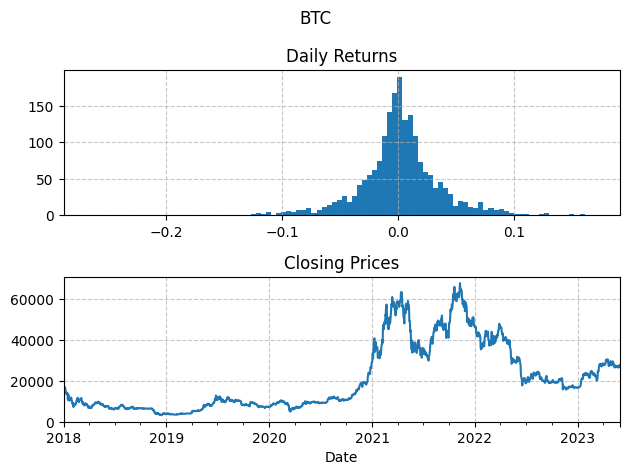

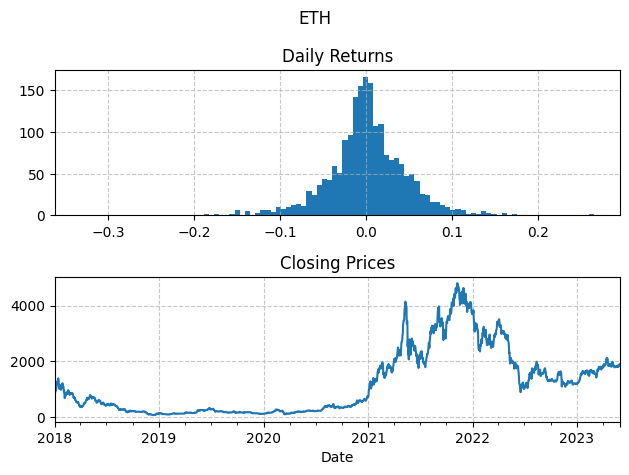

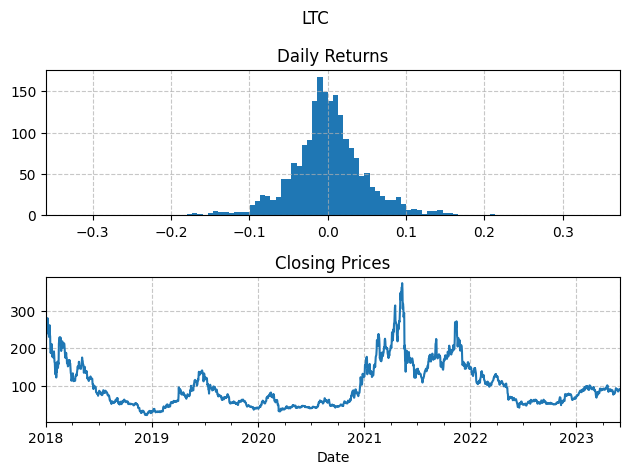

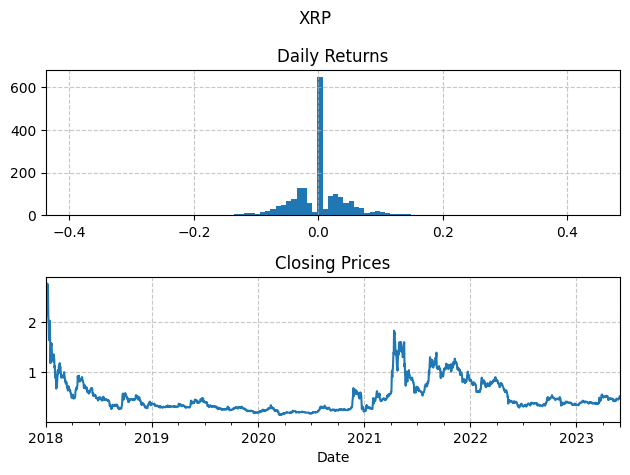

In [3]:
# Plotting the returns and prices for each coin
coins = ['BTC', 'ETH', 'LTC', 'XRP']
for coin in coins:
    coin_returns = f'{coin}__Returns'
    coin_prices = f'{coin}__Close'

    # Appending the new Returns Feature
    data[coin_returns] = data[coin_prices].pct_change()
    plot_returns_and_prices(coin, data[coin_returns], data[coin_prices])

# Droping XRP due to our concerns about data quality.
coins = ['BTC', 'ETH', 'LTC']
data = data.drop(columns=[
    'XRP__Open',
    'XRP__High',
    'XRP__Low',
    'XRP__Close',
    'XRP__Returns',
])

#### Feature selection and generation

##### Adding Technical Indicators

Predicting expectations of the future based on historical open / high / low / close / returns is quite difficult, some would argue impossible without incorpoating additional exogenous data. We did consider incorporating economic variables such as GDP and CPI, however, we have choosen to use technical indicators derived from historical prices instead. The indcators which we utilize are described below:

- **Volatility**: Also known as standard deviation, scaled by the window size of *n* days.

- **Momentum**: This indicator was developed through our own creativity and its calculation can be seen below. This indicator aims to capture how above or below the closing price is relative to the moving average and volatility.

- **RSI**: Measures the speed and magnitude of a security's recent price changes, it is used by technical traders to assess weather an asset is overbought or oversold. 

<p>Momentum = <sup>(Close - Moving Average)</sup> / <sub>(Moving Average * Volatility)</sub></p>

<p>RSI = 100 - <sup> 100</sup> / <sub>(1 + (Average Gain/ Average loss))</sub></p>


We suspect these technical indicators will provide insight into future prices, but this does come with a small cost in terms of data descruction. We considered using a custom transformer class to address the issue of missing data, however our attempts of this led to poor implemtations when it comes to splitting data into training / validation / testing sets. As a result, we will simply drop the first 40 rows of data which contains missing values.

In [4]:
def calculate_rsi(prices, window=40):
    # Calculate the price differences
    delta = prices.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=40).mean()
    avg_loss = loss.rolling(window=window, min_periods=40).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

def transform_prices(prices, window=40):
    """Function to transform prices into volatility and momentum indicators."""
    features = pd.DataFrame(index=prices.index)

    # Creating the new features
    features['Returns'] = prices.pct_change()    
    features['MovingAverage'] = prices.rolling(window=window).mean()
    features['Volatility'] = features['Returns'].rolling(window=window).std() * np.sqrt(window)
    features['RSI'] = calculate_rsi(prices)

    # Creating the momentum feature
    features['Momentum'] = prices - features['MovingAverage']
    features['Momentum'] /= features['MovingAverage'] * features['Volatility']

    # Droping features which the function should not append
    features = features.drop(columns=['MovingAverage', 'Returns'])

    # Returning the new features
    return features

# Using the function to append new features to the data
for coin in coins:
    features = transform_prices(data[coin + '__Close'])
    data = pd.concat([data, features.add_prefix(f'{coin}__')], axis=1)

data = data.sort_index(axis=1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1937 entries, 2018-02-10 to 2023-05-31
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BTC__Close       1937 non-null   float64
 1   BTC__High        1937 non-null   float64
 2   BTC__Low         1937 non-null   float64
 3   BTC__Momentum    1937 non-null   float64
 4   BTC__Open        1937 non-null   float64
 5   BTC__RSI         1937 non-null   float64
 6   BTC__Returns     1937 non-null   float64
 7   BTC__Volatility  1937 non-null   float64
 8   ETH__Close       1937 non-null   float64
 9   ETH__High        1937 non-null   float64
 10  ETH__Low         1937 non-null   float64
 11  ETH__Momentum    1937 non-null   float64
 12  ETH__Open        1937 non-null   float64
 13  ETH__RSI         1937 non-null   float64
 14  ETH__Returns     1937 non-null   float64
 15  ETH__Volatility  1937 non-null   float64
 16  LTC__Close       1937 non-null   float64
 

The below code chunk provides a visual of our indicators. We show these charts to provide the reader with insight into how our technical indcators behave overtime. 

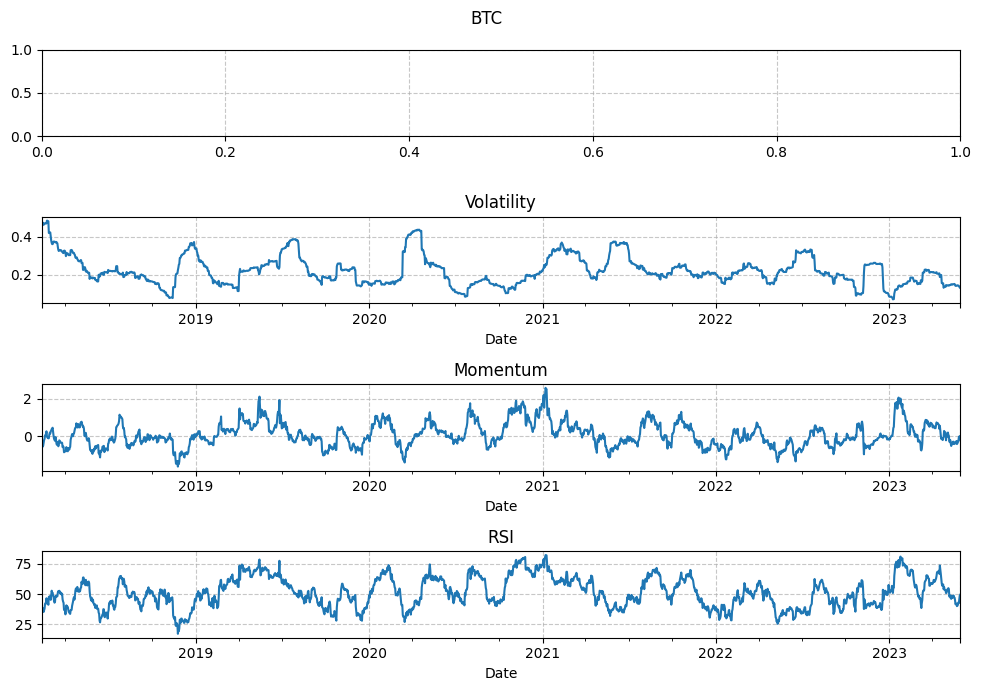

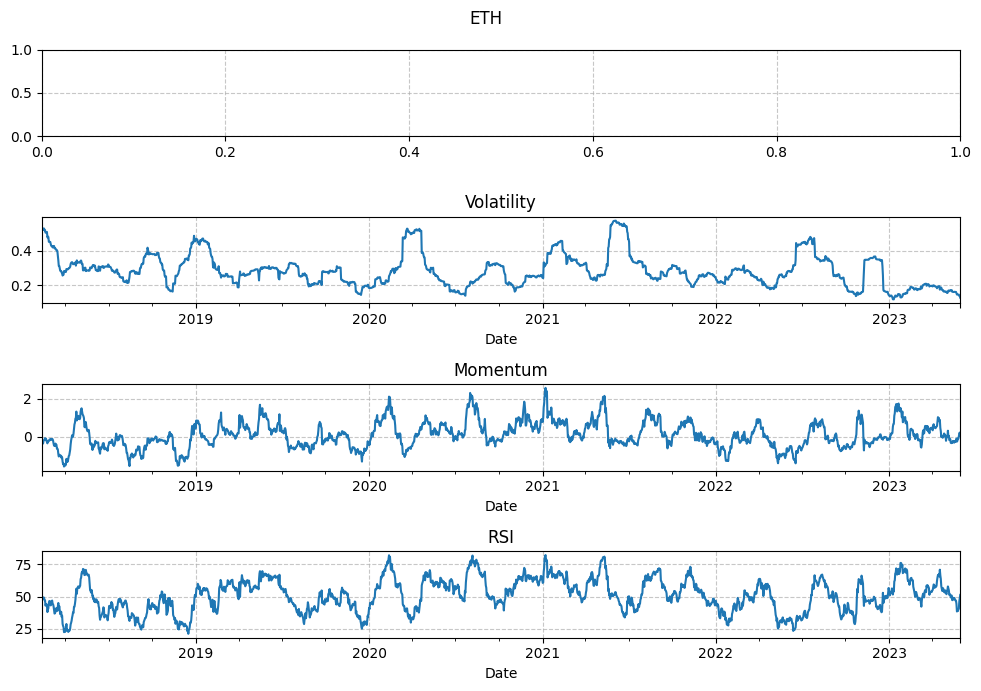

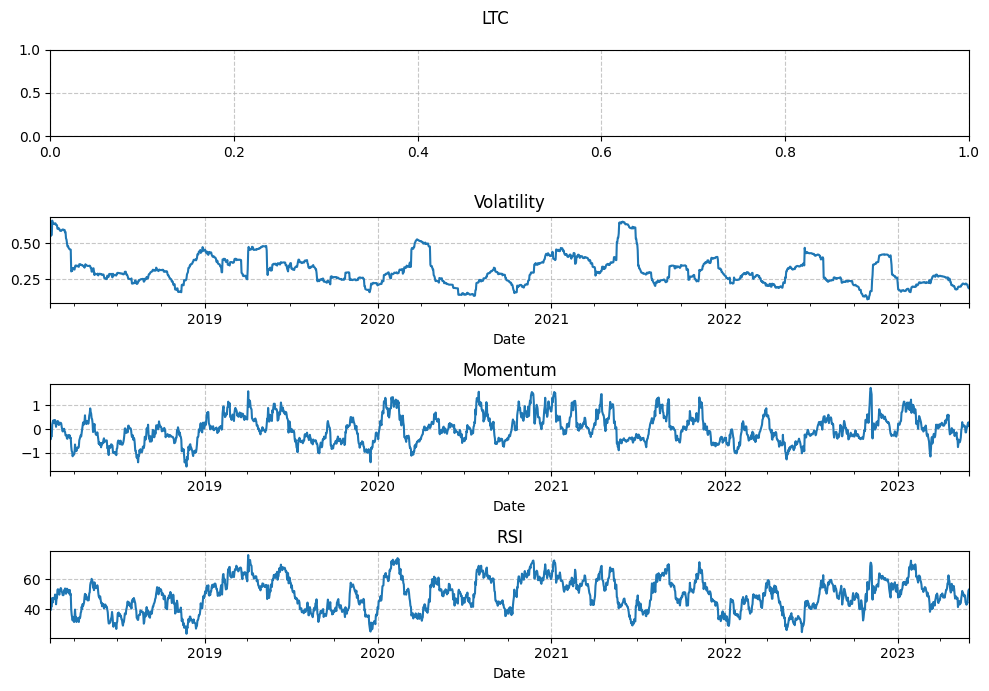

In [5]:
# Plot the technical indicators for each coin against its closing price.
figsize = (10, 7)
for coin in coins:

    # Plot the technical indicators.
    fig, ax = plt.subplots(4, 1, figsize=figsize)
    fig.suptitle(coin)

    # Plot the volatility, momentum, and RSI of each coin.
    data[f'{coin}__Volatility'].plot(ax=ax[1], title='Volatility')
    data[f'{coin}__Momentum'].plot(ax=ax[2], title='Momentum')
    data[f'{coin}__RSI'].plot(ax=ax[3], title='RSI')

    # Apply Grids for all axs
    for axi in ax:
        axi.grid(True, alpha=0.7, linestyle='--')

    plt.tight_layout()
    plt.show()

##### Best Coin Binary Label

For our project, a very useful feature to predict would be the coin with the highest return on t+1. The following code generates a useful target dataset of the best coin's return, and also applies one hot encoding for future multi label classification. 



In [6]:
# Creating a target variable dataset for future predictions
data_target = data[[f'{coin}__Returns' for coin in coins]].shift(1)
data_target = data_target.rename(columns={f'{coin}__Returns': f'{coin}__Returns_t+1' for coin in coins})

# Creating a binary target variable for each coin
best_coin_return = data_target.max(axis=1)
for coin in coins:
    data_target[f'{coin}__BestCoin'] = (data_target[f'{coin}__Returns_t+1'] == best_coin_return).astype(int)

# Dropping the missing row and realigning the data
data_target = data_target.dropna()
data = data.loc[data_target.index]

# Display the target variable dataset
data_target.head()

,BTC__Returns_t+1,ETH__Returns_t+1,LTC__Returns_t+1,BTC__BestCoin,ETH__BestCoin,LTC__BestCoin
Date,,,,,,
2018-02-11,-0.028662,-0.032552,-0.062610,1,0,0
2018-02-12,0.005321,-0.048129,-0.039544,1,0,0
2018-02-13,0.062192,0.068521,0.089218,0,0,1
2018-02-14,-0.030125,-0.028929,-0.017446,0,0,1
2018-02-15,0.083956,0.096531,0.339819,0,0,1


### 3. Model Selection and Implementation [30 Points]

- Good reasons for choosing models
- Reasonable train/test/validation split
- Clear model training and tuning process

#### Plotting and Analysis Functions


For our analysis / results, we have written the below section of functions to abstract away much of the mundane / reusable code to make our project more readable. 

**Please feel free to the KMeans Regime model if you wish.** 

In [7]:
# Creating a returns dataframe for analysis
returns = pd.DataFrame()
for coin in coins:
    returns[coin] = data[coin + '__Returns']

In [8]:
def analyze_regimes_and_get_best_portfolios(returns, regimes):
    """Function to print the average returns of each coin by regime and return portfolio dictionaries."""

    n_regimes = len(np.unique(regimes))
    regime_returns = returns.loc[regimes.index]

    # Print the average returns of each coin by regime and make a portfolio for each regime
    portfolios_by_regime = {}
    for i in range(n_regimes):
        average_returns = regime_returns[regimes == i].mean()

        print(f'\n-- {average_returns.idxmax()} Best coin in Regime {i}')
        print(average_returns)

        # Add the best portfolio for this regime to the dictionary
        best_coin_index = average_returns.idxmax()
        portfolios_by_regime[i] = [1 if coin == best_coin_index else 0 for coin in average_returns.index]

    # Also print out the best coin overall
    overall_average_returns = returns.mean()
    print(f'\n-- Best Coin Overall: {overall_average_returns.idxmax()}')

    # Create the best overall portfolio
    best_coin_index = overall_average_returns.idxmax()
    best_overall_portfolio = [1 if coin == best_coin_index else 0 for coin in overall_average_returns.index]
    best_overall_portfolio = {i: best_overall_portfolio for i in range(n_regimes)}

    return portfolios_by_regime, best_overall_portfolio

In [9]:
def create_portfolio_timeseries(regimes, portfolio_dict, coins):
    """Function to create a portfolio timeseries from a regime timeseries and portfolio dictionary"""

    # Create a portfolio timeseries
    portfolio = pd.DataFrame(np.zeros((len(regimes), len(coins))), index=regimes.index, columns=coins)
    for regime, allocation in portfolio_dict.items():
        portfolio[regimes == regime] = allocation

    return portfolio

In [10]:
def plot_portfolio_backtest(portfolio, benchmark, returns):
    """Function to plot the cumulative returns of a portfolio and its allocation over time"""

    # Calculate the cumulative returns of the portfolio and benchmark
    portfolio_returns = np.sum(returns * portfolio, axis=1)
    benchmark_returns = np.sum(returns * benchmark, axis=1)

    # Create the figure and axis
    fig, ax = plt.subplots(2, 1, figsize=(8, 5))

    # Plot the cumulative returns of the portfolio and benchmark
    ax[0].set_title('Cumulative Returns')
    (1 + portfolio_returns).cumprod().plot(ax=ax[0], label='Portfolio')
    (1 + benchmark_returns).cumprod().plot(ax=ax[0], label='Benchmark', linestyle='--')
    ax[0].grid(True, alpha=0.7, linestyle='--'), ax[0].legend()

    # Plot the rolling 30-day volatility of the portfolio and benchmark
    ax[1].set_title('Rolling 30-Day Volatility')
    portfolio_returns.rolling(window=30).std().plot(ax=ax[1], label='Portfolio')
    benchmark_returns.rolling(window=30).std().plot(ax=ax[1], label='Benchmark', linestyle='--')
    ax[1].grid(True, alpha=0.7, linestyle='--'), ax[1].legend()

    plt.tight_layout()
    plt.show()

    # Print out simple Sharpe ratio metrics
    portfolio_sharpe = portfolio_returns.mean() / portfolio_returns.std()
    benchmark_sharpe = benchmark_returns.mean() / benchmark_returns.std()
    print('\nSharpe Ratio:')
    print(f'Model: {portfolio_sharpe:.4f}')
    print(f'Benchmark: {benchmark_sharpe:.4f}')

    # Create a plot function which plots the portfolio allocations over time
    if portfolio_sharpe > benchmark_sharpe:
        print('Model Outperformed the benchmark.')
    else:
        print('Model Failed to beat the benchmark.')

In [11]:
def plot_portfolio_allocations(portfolio, benchmark):

    # Create the figure and axis
    fig, ax = plt.subplots(2, 1, figsize=(8, 5))
    fig.suptitle('Model and Benchmark Allocations')

    # Plot the portfolio allocation
    portfolio.plot(ax=ax[0], kind='area', stacked=True)   
    ax[0].set_ylim((0, 1)), ax[0].set_ylabel('Portfolio'), ax[0].legend()
    ax[0].grid(True, alpha=0.7, linestyle='--')

    # Plot the portfolio allocation without x or y axis labels
    benchmark.plot(ax=ax[1], kind='area', stacked=True)
    ax[1].set_ylim((0, 1)), ax[1].set_ylabel('Benchmark'), ax[1].legend()
    ax[1].grid(True, alpha=0.7, linestyle='--')

    plt.tight_layout()
    plt.show()

#### KMeans Persistent Regime Model

For our first model, we will keep things simple and cluster our features using KMeans and assume that our regimes will persist for a single day. Which ever coin had the best performance by regime in the training data, will be the coin we hold during the same regime when testing.  

The first 60% of the data will be used for training and 40% for testing. We have no hyper parameters to tune, so there is no validation set and timeseries data should not be shuffled. Again, our benchmark portfolio will be the best perfoming coin in the testing set. 

##### Building the Model
First we introduce a simple pipeline and apply a robust scaler. The robust scaler is quite helpful in reducing our sensitivity to outliers. 

Lets fit a kmeans model for n_clusters from 2 through 10 to determine the optimal number of clusters.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Create the pipeline to only momentum and volatility columns
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('kmeans', KMeans(n_init=10, random_state=42))
])

# Create an X dataset with only the technical indicators for regime detection
technical_indicators = [coin + '__Momentum' for coin in coins]
technical_indicators += [coin + '__Volatility' for coin in coins]
X = data[technical_indicators]

# Split the data into training and testing sets
X_train, X_test = train_test_split(X, shuffle=False, test_size=0.4)

The below plot of silhouette scores indicates that a 2 regime model is ideal. 

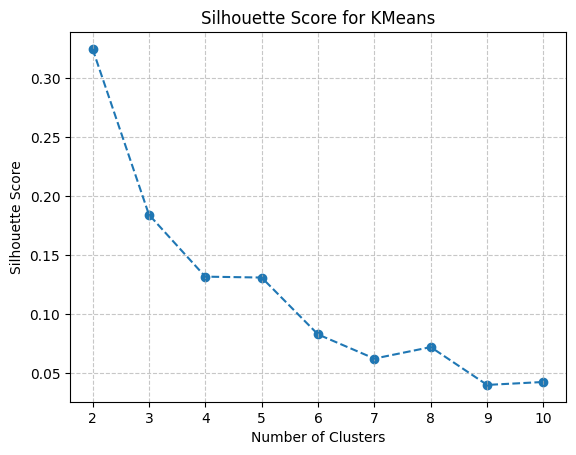

In [13]:
from sklearn.metrics import silhouette_score

# Fit the pipeline to the for n_clusters = {2 - 10} and record silhouette score.
scores = dict()
for n in range(2, 11):
    pipeline.set_params(kmeans__n_clusters=n)
    pipeline.fit(X_train)
    
    # Transform data to get cluster labels
    labels = pipeline['kmeans'].labels_

    # Calculate the silhouette score
    score = silhouette_score(X_train, labels)
    scores[n] = score

# Refitting the model to our best found parameter
n_regimes = 2
pipeline.set_params(kmeans__n_clusters=n_regimes)
pipeline.fit(X_train)

# Plot the scores
fig, ax = plt.subplots()
ax.plot(list(scores.keys()), list(scores.values()), linestyle='--')
ax.scatter(list(scores.keys()), list(scores.values()))
ax.set_title('Silhouette Score for KMeans')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
ax.grid(True, alpha=0.7, linestyle='--')
plt.show()

The below histograms are helpful in determining if the coins exhibit different returns by regime. If they did not, there would not be any point in clustering. 

Analyzing the histograms, it appears that BTC is a better coin to hold in regime 0, while ETH is better to hold in regime 1. In addition, regimes are at least persistent in the training data and appear to be equally likely overall with regime 0 occuring 51% of the time and regime 1 occuring 49% of the time. 


Days In:
Regime 0: 940
Regime 1: 996

Percentage of Time in:
Regime 0: 48.55%
Regime 1: 51.45%

Transition Matrix:
col_0         0         1
row_0                    
0.0    0.955272  0.044728
1.0    0.043173  0.956827


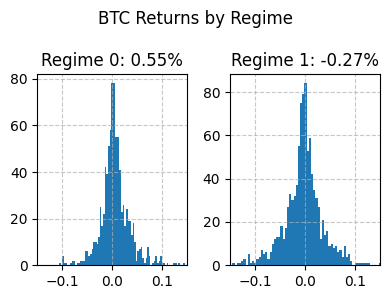

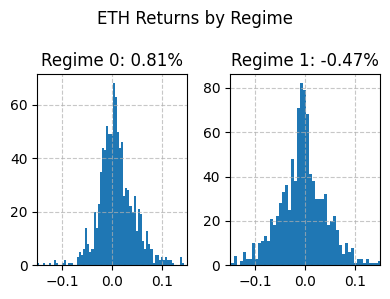

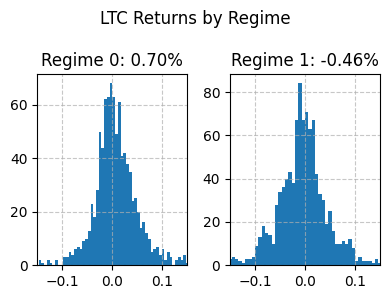

In [14]:
# Assigning a regimes timeseries
regimes = pd.Series(pipeline.predict(X), data.index)
for coin in coins:

    fig, axs = plt.subplots(1, n_regimes, figsize=(2 * n_regimes, 3))
    fig.suptitle(f'{coin} Returns by Regime')

    # Plot a histogram of each regime with the mean return in the title
    for i in range(n_regimes):

        # Filtering down to the coin's returns within the regime
        regime_returns = data.loc[regimes == i, f'{coin}__Returns']

        # Plotting the histogram
        regime_returns.hist(bins=100, ax=axs[i])
        axs[i].set_title(f'Regime {i}: {regime_returns.mean():.2%}')
        axs[i].grid(True, alpha=0.7, linestyle='--')
        axs[i].set_xlim((-0.15, 0.15))

    plt.tight_layout()

# Print the number of days in each regime
print('\nDays In:')
for i in range(n_regimes):
    print(f'Regime {i}: {regimes.value_counts()[i]}')

# Print the percentage of time in each regime
print('\nPercentage of Time in:')
for i in range(n_regimes):
    print(f'Regime {i}: {regimes.value_counts(normalize=True)[i]:.2%}')

# Print a transition matrix. The probability of transitioning from regime a to b
transition_matrix = pd.crosstab(regimes.shift(), regimes, normalize='index')
print('\nTransition Matrix:')
print(transition_matrix)

If we visualize the cluster centers, we can see that regime 0 is best defined as a high volatility low momentum regime while regime 1 has lower volatilty with better momentum. 

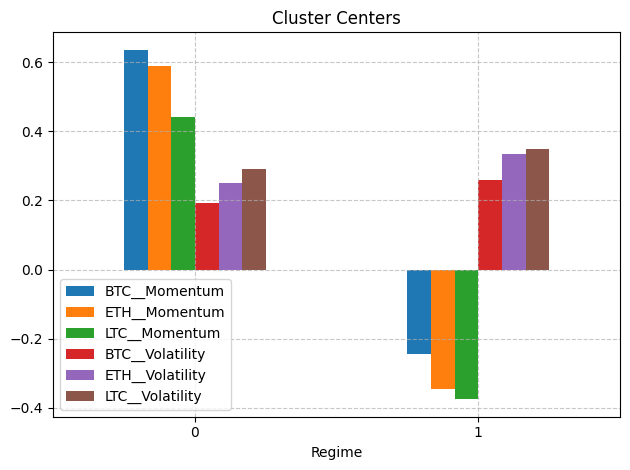

In [15]:

centers = pipeline['kmeans'].cluster_centers_
centers = pd.DataFrame(pipeline['scaler'].inverse_transform(centers), columns=technical_indicators)
centers.index.name = 'Regime'

fig, ax = plt.subplots()
centers.plot(kind='bar', ax=ax)
plt.title('Cluster Centers')
plt.grid(True, alpha=0.7, linestyle='--')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

##### Fit the Model

Here we fit the model print a transition matrix of the test regimes. This shows that our regimes remain persistent in the testing regime.

In [16]:
# Fit the pipeline to the training set and predict both training and test sets.
pipeline.fit(X_train)
regimes_train = pd.Series(pipeline.predict(X_train), X_train.index)
regimes_test = pd.Series(pipeline.predict(X_test), X_test.index)

# Print the transition matrix of the regime test set
transition_matrix = pd.crosstab(regimes_test.shift(1), regimes_test, normalize='index')
print('\nTest Transition Matrix:')
print(transition_matrix)


Test Transition Matrix:
col_0         0         1
row_0                    
0.0    0.951157  0.048843
1.0    0.049351  0.950649


This function prints the best coin to hold by regime. It appears we should hold BTC in regime 0 and ETH in regime 1. 

In [17]:
portfolios, _ = analyze_regimes_and_get_best_portfolios(returns, regimes_train)


-- ETH Best coin in Regime 0
BTC    0.007034
ETH    0.009450
LTC    0.008427
dtype: float64

-- BTC Best coin in Regime 1
BTC   -0.001699
ETH   -0.004581
LTC   -0.003872
dtype: float64

-- Best Coin Overall: ETH


Applying the same function to our testing data, we obtain the benchmark portfolio. ETH is the best coin overall so it is the only coin the benchmark holds.

In [18]:
# During the testing period, ETH was the best overall coin. So our benchmark to beat is a 100% allocation to ETH during the testing period.
_, benchmark = analyze_regimes_and_get_best_portfolios(returns, regimes_test)



-- ETH Best coin in Regime 0
BTC    0.003453
ETH    0.006279
LTC    0.005022
dtype: float64

-- BTC Best coin in Regime 1
BTC   -0.004414
ETH   -0.004972
LTC   -0.005835
dtype: float64

-- Best Coin Overall: ETH


In [19]:
# Formatting our portfolios into a timeseries. Also shifting the portfolios by one day so they may be investable. 
portfolios = create_portfolio_timeseries(regimes_test, portfolios, coins).shift(1)
benchmark = create_portfolio_timeseries(regimes_test, benchmark, coins)

# Also make a set of returns for the backtest
returns_test = benchmark.align(returns, join='inner')[1]



##### Model Backtest

The model has shockingly good results. Beginning the portfolio demonstrates a superior return than the benchmark and does so with less volatility. The daily sharpe ratio is increased from 0.015 to 0.025, this measure is often used in portfolio analysis to indicate a superior portfolio. 

The benefit of KMeans is that it is can at the bare minimum, provide some amount of human insight. In our case, we can say that during periods of high momentum, it is best to own ETH and low momentum periods is is better to own BTC. I would argue that this means BTC is a "risk off" coin which is helpful in turbulent markets while ETH is the coin we should hold once we notice a strong market rally.

The second chart shows our allocation over time, it is a very important chart to review as it represents our portfolio as a timeseries. From the chart, you can see that our regime model recommended a 100% allocation to BTC where shaded in blue (January 2022 for example) and its most recent recommendation was 100% in ETH. The downside to our model, is that it never provides an investor with a 40/40/20 allocation between coins, instead the model always suggests a 100% allocation, simmiliar to a hard max classifier. Investor's will typically avoid 100% allocation, as it is risk to put all of your eggs in a single basket, in later models, we hope address this issue. 

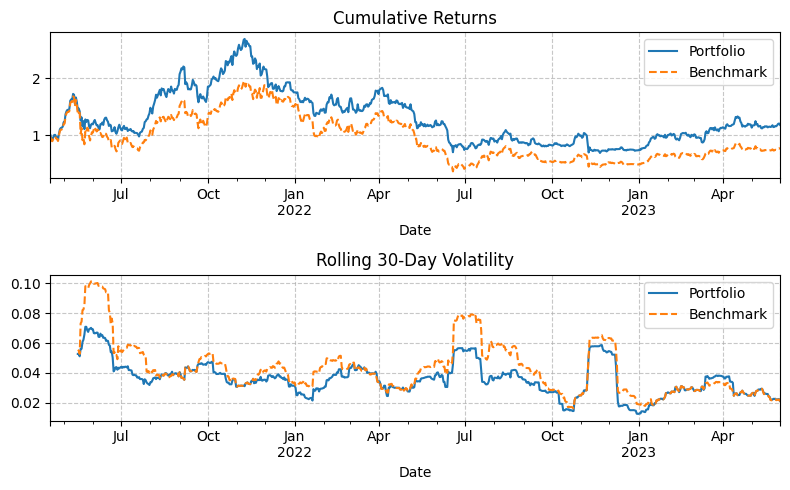


Sharpe Ratio:
Model: 0.0247
Benchmark: 0.0151
Model Outperformed the benchmark.


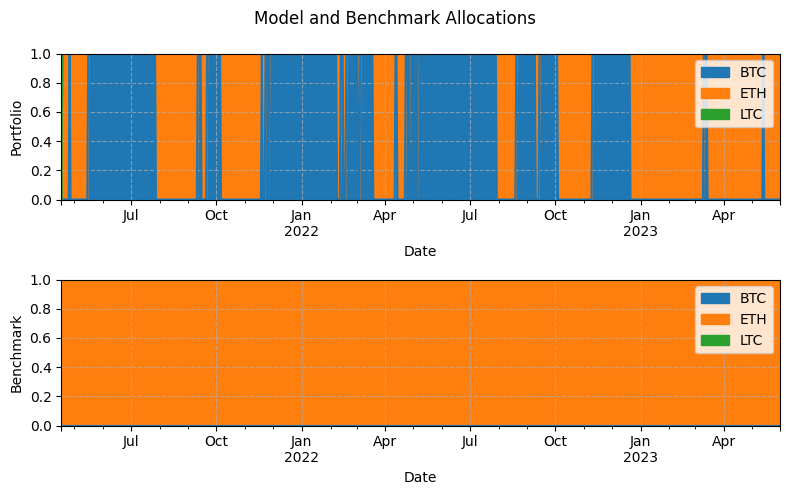

In [20]:
# Plot the portfolio returns and allocation
plot_portfolio_backtest(portfolios, benchmark, returns_test)
plot_portfolio_allocations(portfolios, benchmark)

#### DNN Model

During lecture 14 we learned about the softmax activation and its use in multi label classification. <a href="https://en.wikipedia.org/wiki/Softmax_function">Softmax's</a> activation function is shown below:

<p>σ(z<sub>i</sub>) = <sup>exp(z<sub>i</sub>)</sup> / <sub>Σ exp(z<sub>j</sub>)</sub></p>


This function has two unique features, the first is that the sum of all activations, σ(z<sub>i</sub>), will be equal to 100% and it is impossible for any neuron to contain a negative value. These features are of course by design, as softmax's output is a probability distribution, more specifically, the Categorical distribution. These properties are simmiliar to typical portfolio constraints, allocations of coins must equal 100% reflecting full investment and are constrained to long only positions. This makes softmax a very good choice for an output layer that portfolio managers should consider.

Softmax is the output layer which we use for this deep neural network, and we will be predicting the best returning coin on t+1 as our target variable. making this a multi label classification problem, as there is only one best returning coin each day. 

##### Split the data

To ensure that our model does not see the test set we will use for our backtest, we will split the the training data further into a training and validation sets. we will use 20% of the training data for validation. 

In [27]:
# Suppress warnings from tensorflow
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Define the features and target variable
y = data_target[[col for col in data_target.columns if 'BestCoin' in col]]
X = data.copy()

# Split X and y into training and testing sets
X_train_full, X_test = train_test_split(X, shuffle=False, test_size=0.4)
y_train_full, y_test = train_test_split(y, shuffle=False, test_size=0.4)

# Further split the training set into training and validation sets
X_train, X_val = train_test_split(X_train_full, shuffle=False, test_size=0.2)
y_train, y_val = train_test_split(y_train_full, shuffle=False, test_size=0.2)

# Display the training set
print(y_train.shape)
print(X_train.shape)
y_train.head()

(928, 3)
(928, 24)


,BTC__BestCoin,ETH__BestCoin,LTC__BestCoin
Date,,,
2018-02-11,1,0,0
2018-02-12,1,0,0
2018-02-13,0,0,1
2018-02-14,0,0,1
2018-02-15,0,0,1


##### Hypertuning 

We would like to search a very large of possible models to ensure that we have the best possible model for our task. Our model will consist of the following:
- A Sequential model beginning with a batch normalization layer. 
- (N) number of layers with each layer consisting of a dense layer with (n) neurons and batch normalization.
- The dense layer will contain either a swish or relu activation function paired with l2 regularization. 

The number of layers, neurons per dense layer, activation function, l2 regularization, and learning rate are all variables which we will hyper tune. 

It is important to note, this model does include **l2 regularization** which is how we can implement feature selection in our model. 

In [22]:
import tensorflow as tf
from kerastuner.tuners import Hyperband

# Define the model-building function
def build_model(hp):

    # Creating the hyperparameters to tune
    num_layers = hp.Int('num_layers', min_value=1, max_value=2)
    num_units = hp.Int('num_units', min_value=2, max_value=16, step=2)
    l2_regularizer = hp.Float('l2_regularizer', 0.00, 0.50, step=0.05)
    activation = hp.Choice('activation', values=['relu', 'swish'])

    # Start the model with a batch normalization layer
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]))
    
    # Add hidden layers
    for i in range(num_layers):

        # Add a dense layer with L2 regularization and an activation function (relu or swish)
        model.add(tf.keras.layers.Dense(
            num_units,activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)
        ))

        # Add a batch normalization layer
        model.add(tf.keras.layers.BatchNormalization())

    # Add the output layer with a softmax activation function
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))

    # Compile the model with a Nadam optimizer with accuracy as the metric
    model.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define the tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy', # Optimize the out of sample validation accuracy
    hyperband_iterations=1, # Perform 3 hyperband iterations
    directory='CoinTuners',
    project_name='DNN',
    seed=42
)

# Begin the search for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_val, y_val))

# print the best hyperparameters
print("\n--- Best Hyperparameters ---")
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
for i, key in enumerate(best_hps.values.keys()):
    print(f"{key}: {best_hps.values[key]}")


Trial 254 Complete [00h 00m 23s]
val_accuracy: 0.32188841700553894

Best val_accuracy So Far: 0.5021459460258484
Total elapsed time: 00h 29m 50s

--- Best Hyperparameters ---
num_layers: 1
num_units: 16
activation: swish
l2_regularizer: 0.16
dropout: 0.4
learning_rate: 0.01
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0242


Here we can see a summary of our hypertuned model. 

In [23]:
# Get the best model and refit on the entire training set
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

c:\Users\ryanm\anaconda3\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\ryanm\anaconda3\Lib\site-packages\keras_tuner\src\tuners\hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
c:\Users\ryanm\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', becaus

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 611 (2.39 KB)

 Trainable params: 531 (2.07 KB)

 Non-trainable params: 80 (320.00 B)

##### Refitting and Learning Curves

Now that we have tuned the model and found the above hyperparameters, we refit the model to the full training set. To summarize what I am finding, I notice that the model is highly unstable and the results are not consistent as I refit the model. Reviewing the learning curves, the out of sample metrics are noisy (moving above / below the insample at each epoch) which I believe is sign of overfitting despite my use of l2 regularization, batch normalization, and dropout. 

Additionally, the accuracy of our model is not increasing as much as we would like. The accuracy is slightly above 1/3, at first glance this is good since there are 3 possibilities. However the probability of BTC and LTC is 34%, meaning I could easily beat a 33% accuracy by never picking LTC. To me, this indicates that our model does not have any predictive power, and is a  failure despite my efforts. This happens quite often when applying any sort of prediction to financial timeseries.

For this reason, the next model will incorporate a walk forward optimization which will hopefully improve our model via superior cross validation of timeseries data and reduce our chance of overfitting. 

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3645 - loss: 1.9941 - val_accuracy: 0.4249 - val_loss: 1.9150
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3816 - loss: 2.0870 - val_accuracy: 0.2790 - val_loss: 2.0066
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3592 - loss: 1.9724 - val_accuracy: 0.2790 - val_loss: 1.8422
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3678 - loss: 1.9676 - val_accuracy: 0.3948 - val_loss: 2.1657
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3715 - loss: 2.0814 - val_accuracy: 0.3991 - val_loss: 1.9329
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3704 - loss: 2.1323 - val_accuracy: 0.3562 - val_loss: 2.3941
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3440 - loss: 2.2693 - val_accuracy: 0.3519 - val_loss: 1.9564
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3319 - loss: 2.1092 - val_accuracy: 0.2747 - v

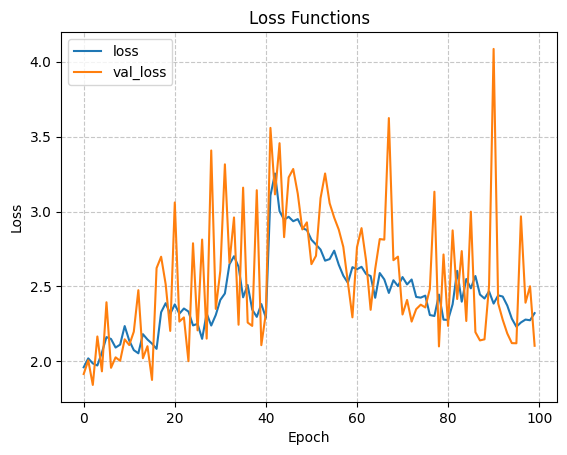

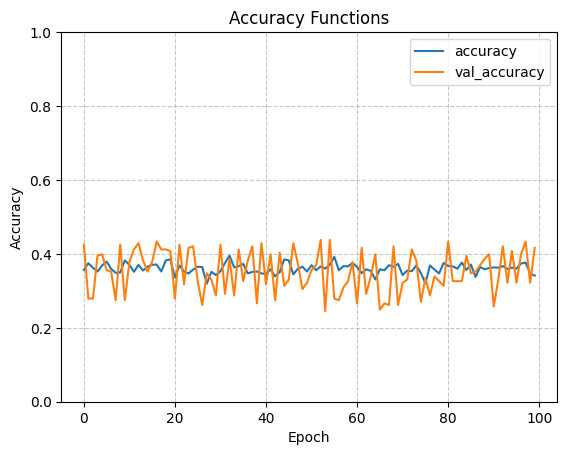

In [58]:
# Refit the model to the training set 
history = best_model.fit(X_train_full, y_train_full, epochs=100, validation_data=(X_val, y_val))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(xlabel="Epoch", ylabel="Loss", title="Loss Functions")
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()

# Plot the accuracy functions
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(
    ylim=(0, 1), xlabel="Epoch", ylabel="Accuracy", title="Accuracy Functions")
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()

# Print the best coin probabilities as noted in the above paragraph
coin_probability = y_test.sum() / len(y_test)
for i, coin in enumerate(coins):
    print(f'{coin} Probability: {coin_probability[i]:.2%}')

##### Back Testing

In addition, I would argue that dropout is a poor choice for portfolio management as it appears that I get a different result each time I fit the model. This is not a good trait to find, which leads me to believe that dropout is a poor choice for a layer when it comes to portfolio management. Perhaps the reason is that we do not have enough data, or perhaps we overfit the model to the validation data. 

When reviewing the learning curves, I notice that our model does have an accuracy score slightly better than . 

For this reason, I would consider these back tests to be irrelevant given that as we add data the model will continue to overfit and yield very different allocations. That being said, if an investor allocated 100% of their capital to the coin which has the highest probability of being tommorow's best coin, the model tends to perform quite well. 

Did it add value?

BTC__BestCoin    0.340645
ETH__BestCoin    0.345806
LTC__BestCoin    0.313548
dtype: float64

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


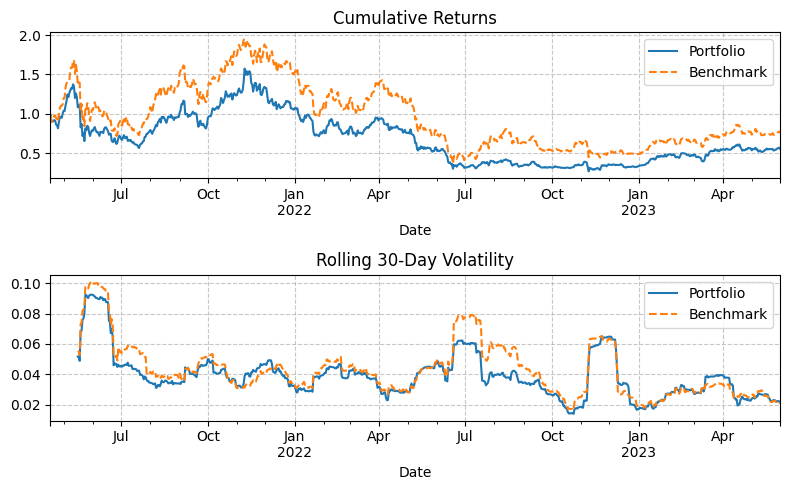


Sharpe Ratio:
Model: 0.0026
Benchmark: 0.0151
Model Failed to beat the benchmark.


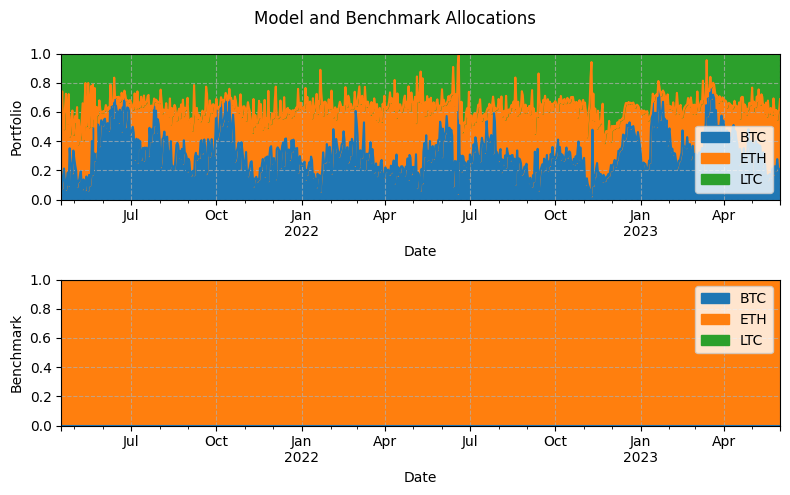

In [60]:
dnn_portfolios_softmax = pd.DataFrame(best_model.predict(X_test), index=X_test.index, columns=coins)

# Plot the portfolio returns and allocation
plot_portfolio_backtest(pd.DataFrame(dnn_portfolios_softmax, index=X_test.index, columns=coins), benchmark, returns_test)
plot_portfolio_allocations(pd.DataFrame(dnn_portfolios_softmax, index=X_test.index, columns=coins), benchmark)


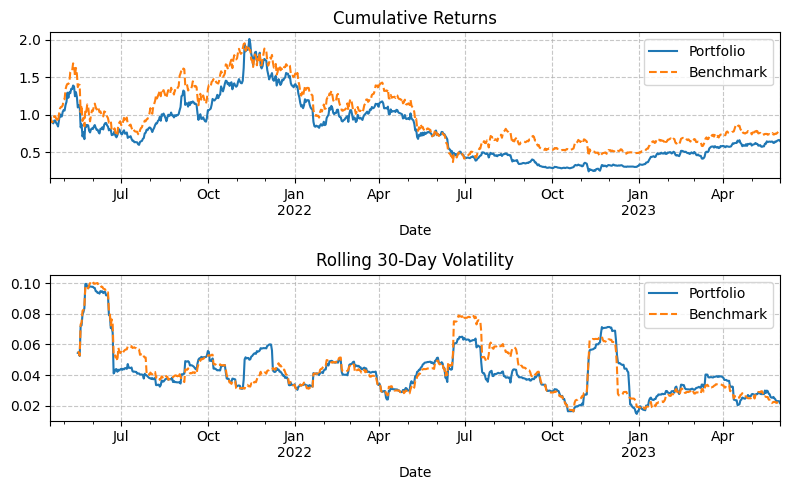


Sharpe Ratio:
Model: 0.0096
Benchmark: 0.0151
Model Failed to beat the benchmark.


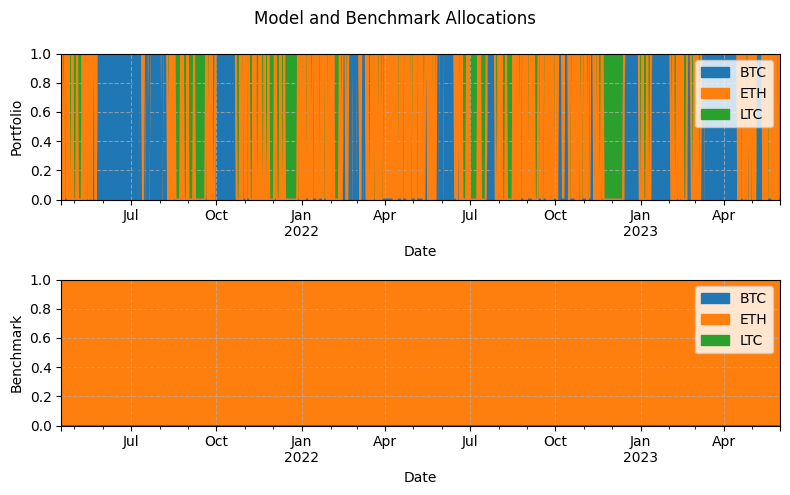

In [61]:
# Creating the hardmax strategy from the softmax strategy
best_coin_pred = dnn_portfolios_softmax.idxmax(axis=1)
dnn_portfolios_hardmax = pd.DataFrame(0, index=X_test.index, columns=coins)
for coin in coins:
    dnn_portfolios_hardmax[coin] = (best_coin_pred == coin).astype(int)

plot_portfolio_backtest(pd.DataFrame(dnn_portfolios_hardmax, index=X_test.index, columns=coins), benchmark, returns_test)
plot_portfolio_allocations(pd.DataFrame(dnn_portfolios_hardmax, index=X_test.index, columns=coins), benchmark)

#### MLP Classifier with Walkforward Optimization

Thus far, we have trained a simple KMeans model and a complex DNN to generate our portfolios. However, I believe would like to improve the robustness of our model and implement a walk forward optimization splitting strategy when hypertuning parameters. For this model we will again attempt to predict tommorow's best coin using the same training used for the above DNN model. 

##### Splitting

This split routine will not require a validation set as this will be handeled by Sklearn's TimeSeriesSplit Class

In [85]:
# Define the features and target variable
y = data_target[[col for col in data_target.columns if 'Returns_t+1' in col]]
X = data.copy()

# Split X and y into training and testing sets
X_train, X_test = train_test_split(X, shuffle=False, test_size=0.4)
y_train, y_test = train_test_split(y, shuffle=False, test_size=0.4)

# Display the training set
print(y_train.shape)
print(X_train.shape)
y_train.head()

(1161, 3)
(1161, 24)


,BTC__Returns_t+1,ETH__Returns_t+1,LTC__Returns_t+1
Date,,,
2018-02-11,-0.028662,-0.032552,-0.062610
2018-02-12,0.005321,-0.048129,-0.039544
2018-02-13,0.062192,0.068521,0.089218
2018-02-14,-0.030125,-0.028929,-0.017446
2018-02-15,0.083956,0.096531,0.339819


##### Build Model

Build the model and setout a parameter. 

 and tune a RandomForestClassifier with GridSearchCV and TimeSeriesSplit

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    n_jobs=-1,
    verbose=1
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

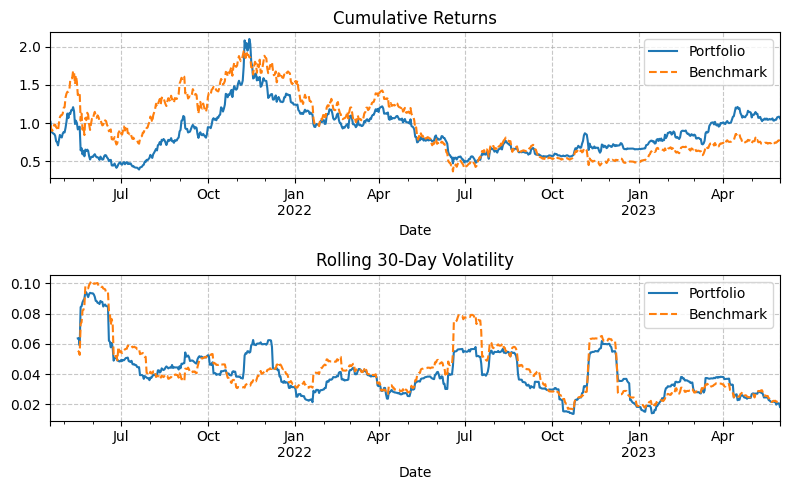


Sharpe Ratio:
Model: 0.0238
Benchmark: 0.0151
Model Outperformed the benchmark.


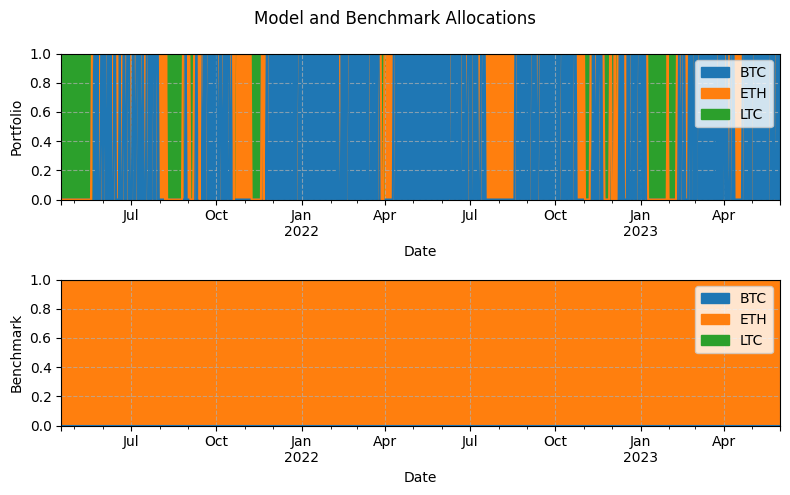

LTC__Momentum      0.236196
BTC__Momentum      0.132330
LTC__Returns       0.101580
BTC__Returns       0.097997
ETH__Momentum      0.067012
ETH__Returns       0.050328
ETH__Volatility    0.046377
BTC__RSI           0.036301
LTC__Volatility    0.033628
ETH__RSI           0.029195
dtype: float64

In [90]:
y_pred = pd.DataFrame(grid_search.predict(X_test), index=X_test.index, columns=coins)

# Creating the hardmax strategy from the softmax strategy
best_coin_pred = y_pred.idxmax(axis=1)
rf_portfolios = pd.DataFrame(0, index=X_test.index, columns=coins)
for coin in coins:
    rf_portfolios[coin] = (best_coin_pred == coin).astype(int)

plot_portfolio_backtest(rf_portfolios, benchmark, returns_test)
plot_portfolio_allocations(rf_portfolios, benchmark)

# Print the most important features
feature_importances = pd.Series(grid_search.best_estimator_.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances.head(10)


BTC Residual vs Actual:
Std of Residuals: 0.033875
Std of Actual Returns: 0.034842
Variability Ratio: 0.972253


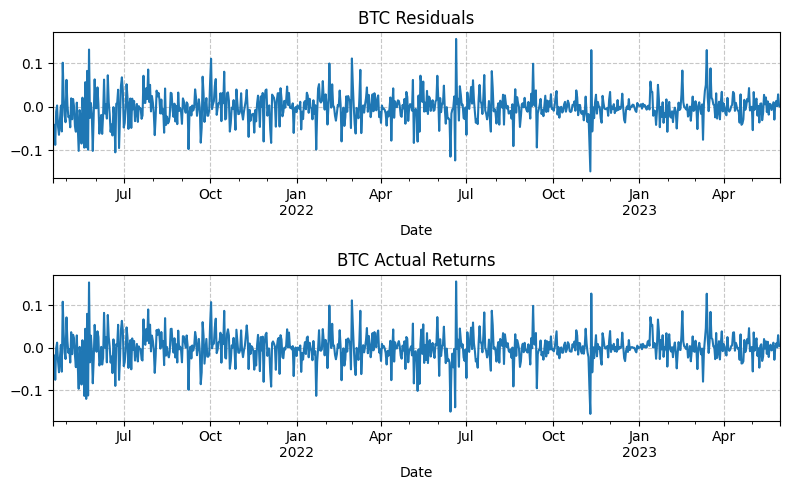


ETH Residual vs Actual:
Std of Residuals: 0.043963
Std of Actual Returns: 0.045611
Variability Ratio: 0.963864


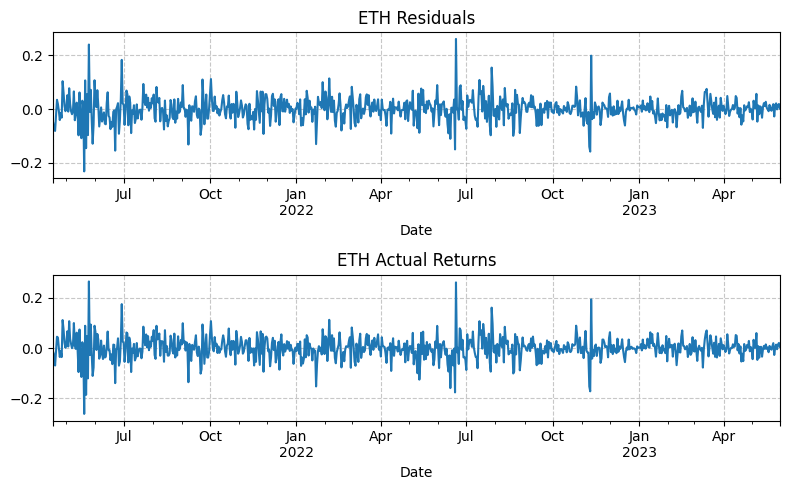


LTC Residual vs Actual:
Std of Residuals: 0.047141
Std of Actual Returns: 0.049239
Variability Ratio: 0.957395


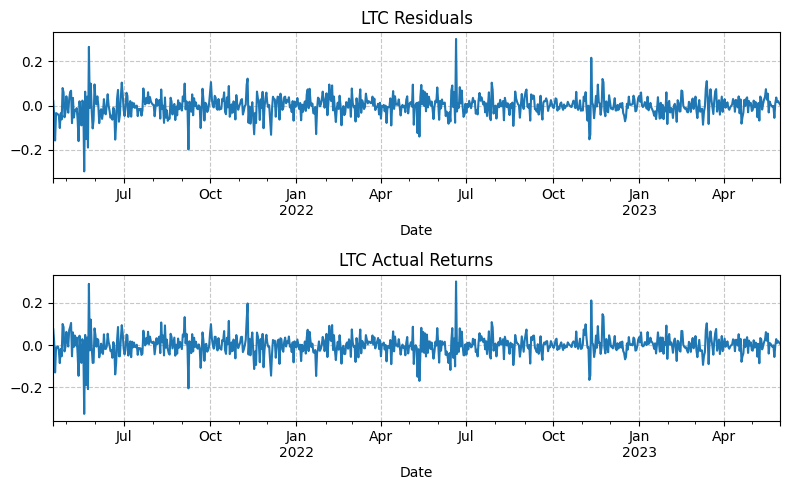

In [104]:
# Plot the residuals of the against the actual returns

# Calculate the residuals
residuals = pd.DataFrame(y_test.to_numpy() - y_pred.to_numpy(), index=y_test.index, columns=coins)

for coin in coins:

    # Create the figure and axis
    fig, ax = plt.subplots(2, 1, figsize=(8, 5))

    # Plot the residuals of the model
    resid = residuals[coin]
    residuals[coin].plot(title=f'{coin} Residuals', ax=ax[0])
    ax[0].grid(True, alpha=0.7, linestyle='--')


    # Plot the actual returns of the coin
    actual = y_test[coin + '__Returns_t+1']
    actual.plot(title=f'{coin} Actual Returns', ax=ax[1])
    ax[1].grid(True, alpha=0.7, linestyle='--')

    # Print the standard deviation of the residuals and actual returns
    print(f'\n{coin} Residual vs Actual:')
    print('Std of Residuals:', round(resid.std(), 6))
    print('Std of Actual Returns:', round(actual.std(), 6))
    print('Variability Ratio:', round(resid.std() / actual.std(), 6))

    plt.tight_layout()
    plt.show()

<Axes: title={'center': 'Mean Centered Predictions'}, xlabel='Date'>

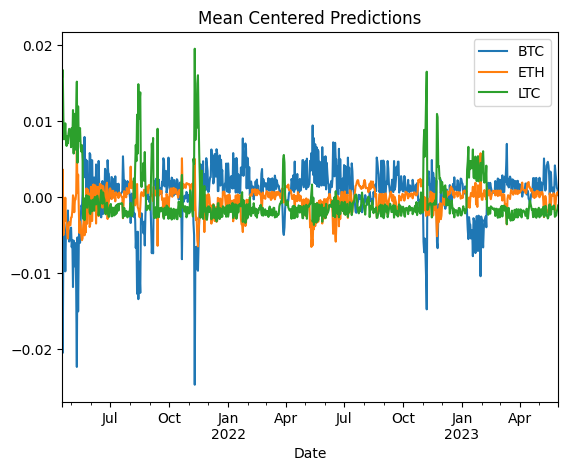

In [111]:
y_pred.sub(y_pred.mean(axis=1), axis=0).plot(title='Mean Centered Predictions')